<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Taxonomic classification of Main Belt Asteroids in DP0.3</b> <br>
Contact author(s): Valerio Carruba, Julio Camargo, Safwan Aljbaae, based on a notebook originally developed by Jeff Carlin.<be>
Last verified to run: 2024-04-20 <br>
LSST Science Pipelines version: Weekly 2024_10 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

### Objectives

To obtain the taxonomical classification of asteroids in a given region of the main belt, based on the available photometric data.  We use the approach of DeMeo and Carry (2023). This example concentrates on the central main-belt at high inclinations.

### 1.1. Package Imports

Import general python packages and the Rubin TAP service utilities.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pandas as pd
from lsst.rsp import get_tap_service


## 1.2. Create the Rubin SSO TAP Service client

The DP0.3 data sets are available via the Table Access Protocol (TAP) service,
and can be accessed with ADQL (Astronomical Data Query Language) statements.

TAP provides standardized access to catalog data for discovery, search, and retrieval.
Full <a href="http://www.ivoa.net/documents/TAP">documentation for TAP</a> is provided by the International Virtual Observatory Alliance (IVOA).
ADQL is similar to SQL (Structured Query Langage).
The <a href="http://www.ivoa.net/documents/latest/ADQL.html">documentation for ADQL</a> includes more information about syntax and keywords.

Get an instance of the SSO TAP service, and assert that it exists.

> **Notice:** The DP0.3 TAP service is called `ssotap` (whereas `tap` is used for DP0.2).

In [8]:
service = get_tap_service("ssotap")
assert service is not None

### 1.3 Define Functions and Parameters

Define a function to convert a given perihelion distance (`q`) and eccentricity (`e`) to an orbital semi-major axis (`a`). Their relationship is defined by q = a(1-e).

In [9]:
def calc_semimajor_axis(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
      calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: float
        Distance at perihelion, in au.
    e: float
        Orbital eccentricity.

    Returns
    -------
    a: float
        Semi-major axis of the orbit, in au.
        q = a(1-e), so a = q/(1-e)
    """

    return q / (1.0 - e)

## 2. Orbital parameters of Solar System objects

Query the DP0.3 catalogs, joining the MPCORB and SSObject tables on their ssObjectId. One _could_ retrieve the entire catalog (containing millions of rows), but that query may take a long time. To minimize query time but still extract a large sample, we use a range of `ssObjectId` values.

In [10]:
df_mpc_sso_all = service.search("SELECT mpc.ssObjectId, mpc.fullDesignation, mpc.e, mpc.incl, \
                            mpc.q, mpc.peri, mpc.node,mpc.tperi,\
                            sso.ssObjectId, sso.g_H, sso.r_H, sso.i_H, sso.z_H \
                            FROM dp03_catalogs_10yr.MPCORB as mpc \
                            JOIN dp03_catalogs_10yr.SSObject as sso \
                            ON mpc.ssObjectId = sso.ssObjectId \
                            WHERE mpc.ssObjectId < 9223370875126069107 \
                            AND mpc.ssObjectId > 8331137166374808576 \
                            AND sso.numObs > 70").to_table().to_pandas()

# SELECT REGION OF INTEREST
mask= (df_mpc_sso_all.incl > 30) 
df_mpc_sso = df_mpc_sso_all.loc[mask]

print('The query returned ', len(df_mpc_sso), ' results.')
df_den=df_mpc_sso['fullDesignation']
df_mpc_sso.to_csv('high_i.csv', sep=' ', header=None)
#df_mpc_sso
#df_den.to_csv('high_i_den.csv', sep=' ', header=None)

The query returned  985  results.


### 2.1 Overall orbital properties

First, calculate the semi-major axis of each object's orbit, using the function we defined above.  We also calculate the object mean anomaly using the time of passage at perihelion.

In [11]:
import math
a = calc_semimajor_axis(df_mpc_sso.q, df_mpc_sso.e)
df_mpc_sso.loc[:,'a']= a
# Select objects in the central main belt
mask = (df_mpc_sso.a > 2.508) & (df_mpc_sso.a < 2.8258) 
df_mpc_sso = df_mpc_sso.loc[mask]

# Time for which you want to compute the mean anomaly
t =  59600.000000

tperi=df_mpc_sso.peri
# Mass of the Sun in kilograms
MSUN = 1.989e30 

# au
au= 149597871
# Compute the orbital period
Period = np.sqrt((4 * math.pi**2 * (a*au)**3) / (6.67430e-11 * MSUN))

#print(T)

# Compute the mean anomaly
M = 2 * math.pi * (t - tperi) / Period
#print(M)
# Save Particles file
df_mpc_sso.loc[:,'M']= M
data_sims=df_mpc_sso[['a','e','incl','peri','node','M']]
data_sims.to_csv('Particles.txt', sep=' ', header=None)
idx=2
degtorad=np.pi/180.0
#print(data_sims.iloc[idx,:])
a_ast=data_sims.iloc[idx,0]
e_ast=data_sims.iloc[idx,1]
inc_ast=data_sims.iloc[idx,2]*degtorad
Omega_ast=data_sims.iloc[idx,3]*degtorad
omega_ast=data_sims.iloc[idx,4]*degtorad
M_ast=data_sims.iloc[idx,5]*degtorad

#print(np.pi)
#print(data_sims.iloc[idx,:])

/tmp/ipykernel_718/554332809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpc_sso.loc[:,'a']= a
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Plot the orbital inclination and the eccentricity vs. semi-major axis. Note that we plot the sine of the inclination so its range is limited to values between 0 and 1.

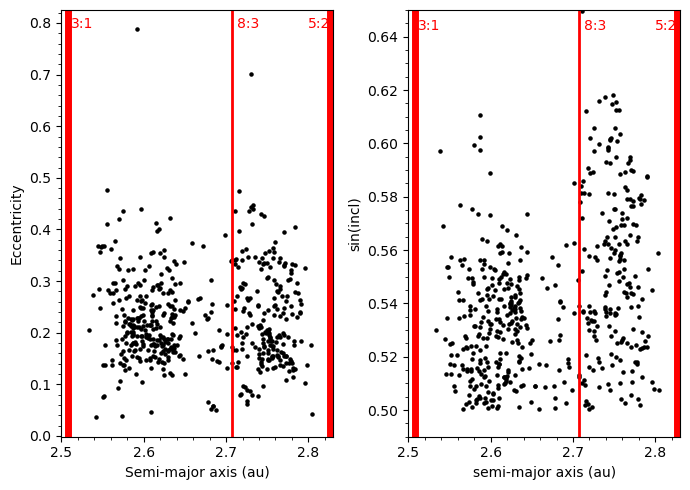

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].scatter(df_mpc_sso.a, df_mpc_sso.e, s=5, c='k')
axs[0].axvline(x=2.5082, c='r', linewidth=5)
axs[0].text(2.512,0.79,'3:1', c='r')
axs[0].axvline(x=2.707, c='r', linewidth=2)
axs[0].text(2.713,0.79,'8:3', c='r')
axs[0].axvline(x=2.826, c='r', linewidth=5)
axs[0].text(2.80,0.79,'5:2', c='r')
axs[0].set_xlabel('Semi-major axis (au)')
axs[0].set_ylabel('Eccentricity')
axs[0].minorticks_on()
axs[0].set_xlim(2.5, 2.85)

axs[1].scatter(df_mpc_sso.a, np.sin(df_mpc_sso.incl*degtorad),s=5, c='k')
axs[1].axvline(x=2.5082, c='r', linewidth=5)
axs[1].text(2.512,0.6425,'3:1', c='r')
axs[1].axvline(x=2.707, c='r', linewidth=2)
axs[1].text(2.713,0.6425,'8:3', c='r')
axs[1].axvline(x=2.826, c='r', linewidth=5)
axs[1].text(2.80,0.6425,'5:2', c='r')
axs[1].set_ylabel('sin(incl)')
axs[1].set_xlabel('semi-major axis (au)')
axs[1].set_xlim(2.5,2.83)
axs[1].set_ylim(0.49, 0.65)
axs[1].minorticks_on()
plt.tight_layout()
plt.show()
plt.close()

### 2.2 Overall physical properties


For Solar System objects, absolute magnitudes are defined to be for an object 1 au from the Sun and 1 au 
from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.

Absolute magnitudes are derived by correcting for distance, fitting a function to the relationship between 
absolute magnitude and phase, and evaluating the function at a phase of 0 deg.

The process for fitting phase curves will be covered in another tutorial.

Calculate colors in the Rubin filters for the `SSObjects` that have absolute magnitudes.

In [25]:
df_mpc_sso.loc[:,'gr'] = df_mpc_sso.loc[:,'g_H'] - df_mpc_sso.loc[:,'r_H']
df_mpc_sso.loc[:,'ri'] = df_mpc_sso.loc[:,'r_H'] - df_mpc_sso.loc[:,'i_H']
df_mpc_sso.loc[:,'iz'] = df_mpc_sso.loc[:,'i_H'] - df_mpc_sso.loc[:,'z_H']

Plot color-color diagrams as 2-dimensional histograms (heatmaps).

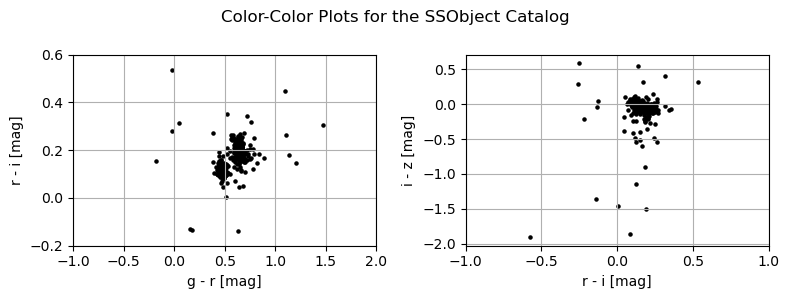

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

h = ax[0].scatter(df_mpc_sso['gr'], df_mpc_sso['ri'], s=5, c='k')
#                 bins=(np.arange(-0.5, 1.5, 0.01),
#                       np.arange(-0.5, 0.75, 0.01)),
#                 norm='log')
ax[0].set_xlabel('g - r [mag]')
ax[0].set_ylabel('r - i [mag]')
ax[0].set_xlim(-1,2)
ax[0].set_ylim(-0.2,0.6)
ax[0].grid()
#plt.colorbar(h[3])

h = ax[1].scatter(df_mpc_sso['ri'], df_mpc_sso['iz'], s=5, c='k')
#                 bins=(np.arange(-0.5, 0.75, 0.01),
#                       np.arange(-0.75, 0.5, 0.01)),
#                 norm='log')
ax[1].set_xlabel('r - i [mag]')
ax[1].set_ylabel('i - z [mag]')
ax[1].set_xlim(-1,1)
ax[1].grid()
#plt.colorbar(h[3])

fig.suptitle('Color-Color Plots for the SSObject Catalog')
fig.tight_layout()
plt.show()

Compute the gri spectral slope and plot a histogram of its distribution.

-10681.8564453125 209762.3 107403896.0


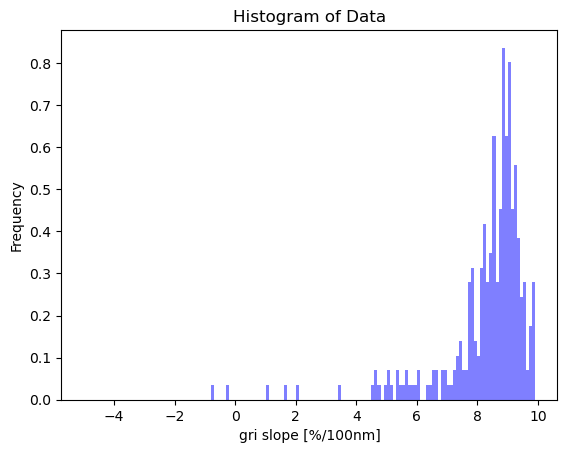

In [27]:
MSun_G = -26.34
MSun_R = -27.04
MSun_I = -27.38
MSun_Z = -27.56

lambda_G = 467.3
lambda_I = 745.9
lambda_R = 614.2
lambda_Z = 892.5

ig= (df_mpc_sso.loc[:, 'i_H'] - df_mpc_sso.loc[:, 'g_H'])
rg= (df_mpc_sso.loc[:, 'r_H'] - df_mpc_sso.loc[:, 'g_H'])
iz= (df_mpc_sso.loc[:, 'i_H'] - df_mpc_sso.loc[:, 'z_H'])

#plt.scatter(ig, rg, s=5, color='k')
#plt.xlabel('i - g')
#plt.ylabel('r - g')
#plt.show()

R_IG = np.power(10, -0.4 * (ig - (MSun_I - MSun_G)))
R_RG = np.power(10, -0.4 * (rg - (MSun_R - MSun_G)))
#R_IG = 10^(0.4*((df_mpc_sso.loc[:,'i_H']-df_mpc_sso.loc[:,'g_H'])-(MSun_I-MSun_G)))
#R_RG = 10^(0.4*((df_mpc_sso.loc[:,'r_H']-df_mpc_sso.loc[:,'g_H'])-(MSun_I-MSun_G)))

#print(R_IG,R_RG)

slope = 10000* (R_RG - R_IG) / abs(lambda_R - lambda_I)
print(min(slope), np.mean(slope),max(slope))
plt.hist(slope, bins=np.arange(-5,10,0.1), alpha=0.5, color='blue', density=True)
plt.xlabel('gri slope [%/100nm]')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
#plt.axis([ -300, 10, 0, 0.01])
#plt.grid(True)
plt.show()


Plot classification scheme.  We are using the DeMeo and Carry (2013), Icarus, 226, 723 approach. The asteroid taxonomy is assigned depending on the location of the asteroid in the (gri slope, i-z) plane, according to the scheme shown in the figure below.

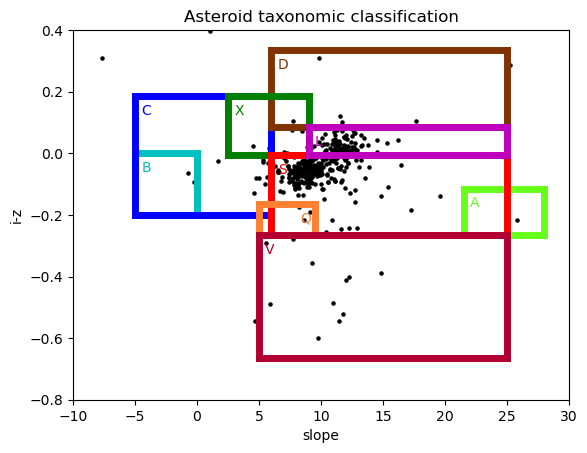

In [28]:
plt.scatter(slope, iz, color='k', s=5)
# A-types
x1=21.5
x2=28.0
y1=-0.265
y2=-0.115

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color=[0.4, 1.0, 0.1], linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color=[0.4, 1.0, 0.1], linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color=[0.4, 1.0, 0.1], linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color=[0.4, 1.0, 0.1], linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'A', color=[0.4, 1.0, 0.1])

# B-types
x1=-5.0
x2=0.0
y1=-0.2
y2=0.0

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color='c', linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color='c', linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color='c', linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color='c', linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'B', color='c')

# C-types
x1=-5.0
x2=6.0
y1=-0.2
y2=0.185

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color='b', linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color='b', linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color='b', linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color='b', linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'C', color='b')

# D-types
x1=6.0
x2=25.0
y1=0.085
y2=0.335

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color=[0.5,0.2,0], linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color=[0.5,0.2,0], linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color=[0.5,0.2,0], linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color=[0.5,0.2,0], linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'D', color=[0.5,0.2,0])

# X-types
x1=2.5
x2=9.0
y1=-0.005
y2=0.185

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color='g', linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color='g', linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color='g', linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color='g', linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'X', color='g')

# S-types
x1=6.0
x2=25.0
y1=-0.265
y2=-0.005

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color='r', linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color='r', linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color='r', linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color='r', linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'S', color='r')

# L-types
x1=9.0
x2=25.0
y1=-0.005
y2=0.085

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color='m', linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color='m', linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color='m', linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color='m', linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'L', color='m')

# Q-types
x1=5.0
x2=9.5
y1=-0.265
y2=-0.165

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color=[1, 0.5, 0.2], linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color=[1, 0.5, 0.2], linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color=[1, 0.5, 0.2], linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color=[1, 0.5, 0.2], linestyle='-', linewidth=5)
plt.text(x2-1.2,y2-0.06, 'Q', color=[1, 0.5, 0.2])

# V-types
x1=5.0
x2=25.0
y1=-0.665
y2=-0.265

xx=[x1,x2]
yy=[y1,y1]
plt.plot(xx,yy, color=[0.7, 0, 0.2], linestyle='-', linewidth=5)
xx=[x1,x2]
yy=[y2,y2]
plt.plot(xx,yy, color=[0.7, 0, 0.2], linestyle='-', linewidth=5)
xx=[x1,x1]
yy=[y1,y2]
plt.plot(xx,yy, color=[0.7, 0, 0.2], linestyle='-', linewidth=5)
xx=[x2,x2]
yy=[y1,y2]
plt.plot(xx,yy, color=[0.7, 0, 0.2], linestyle='-', linewidth=5)
plt.text(x1+0.5,y2-0.06, 'V', color=[0.7, 0, 0.2])

plt.title('Asteroid taxonomic classification')
plt.xlabel('slope')
plt.ylabel('i-z')
plt.xlim([-10,30])
plt.ylim([-0.8,0.4])
plt.savefig('Taxonomy_LSST.png', dpi=300)
plt.show()

We perform the taxonomic analysis and create a histogram of the spectral classes.

Text(0.5, 0, 'Type')

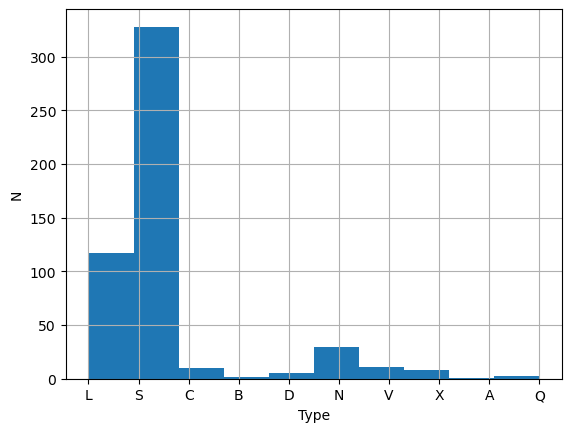

In [29]:
df_mpc_sso.loc[:,'slope']=slope
df_mpc_sso.loc[:,'Tax'] = 'N' 

# Define the desired interval for iz and slope
iz_min = -0.2
iz_max = 0.185
slope_min = -5
slope_max = 6

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'C' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'C'

# Define the desired interval for iz and slope
iz_min = -0.2
iz_max = 0.0
slope_min = -5
slope_max = 0

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'B'

# Define the desired interval for iz and slope
iz_min = -0.005
iz_max = 0.185
slope_min = 2.5
slope_max = 9

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'X'

# Define the desired interval for iz and slope
iz_min = 0.085
iz_max = 0.335
slope_min = 6
slope_max = 25

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'D'

# Define the desired interval for iz and slope
iz_min = -0.005
iz_max = 0.085
slope_min = 9
slope_max = 25

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'L'

# Define the desired interval for iz and slope
iz_min = -0.265
iz_max = -0.005
slope_min = 6
slope_max = 25

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'S'

# Define the desired interval for iz and slope
iz_min = -0.265
iz_max = -0.165
slope_min = 5
slope_max = 9.5

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'Q'

# Define the desired interval for iz and slope
iz_min = -0.265
iz_max = -0.115
slope_min = 21.5
slope_max = 28.0

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'B' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'A'
# Define the desired interval for iz and slope
iz_min = -0.665
iz_max = -0.265
slope_min = 5
slope_max = 25

# Create a boolean mask based on the conditions
mask = (df_mpc_sso['iz'].between(iz_min, iz_max)) & (df_mpc_sso['slope'].between(slope_min, slope_max))

# Assign 'V' to the 'Tax' column for the selected objects
df_mpc_sso.loc[mask, 'Tax'] = 'V'
df_mpc_sso.Tax.hist()
plt.ylabel('N')
plt.xlabel('Type')

Plot the asteroids in the (a,sin(i)) domain with their assigned taxonomy.

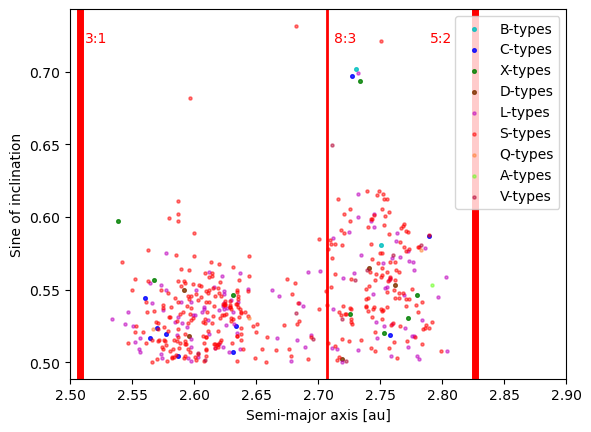

In [32]:
B_types=df_mpc_sso[df_mpc_sso.Tax=='B']
C_types=df_mpc_sso[df_mpc_sso.Tax=='C']
X_types=df_mpc_sso[df_mpc_sso.Tax=='X']
D_types=df_mpc_sso[df_mpc_sso.Tax=='D']
L_types=df_mpc_sso[df_mpc_sso.Tax=='L']
S_types=df_mpc_sso[df_mpc_sso.Tax=='S']
Q_types=df_mpc_sso[df_mpc_sso.Tax=='Q']
A_types=df_mpc_sso[df_mpc_sso.Tax=='A']
V_types=df_mpc_sso[df_mpc_sso.Tax=='V']
#print(V_types)
plt.figure()
plt.scatter(B_types.a, np.sin(B_types.incl*np.pi/180.), s=7, color='c', label='B-types', alpha=0.8)
plt.scatter(C_types.a, np.sin(C_types.incl*np.pi/180.), s=7, color='b', label='C-types', alpha=0.8)
plt.scatter(X_types.a, np.sin(X_types.incl*np.pi/180.), s=7, color='g', label='X-types', alpha=0.8)
plt.scatter(D_types.a, np.sin(D_types.incl*np.pi/180.), s=7, color=[0.5,0.2,0], label='D-types', alpha=0.8)
plt.scatter(L_types.a, np.sin(L_types.incl*np.pi/180.), s=5, color='m', label='L-types', alpha=0.5)
plt.scatter(S_types.a, np.sin(S_types.incl*np.pi/180.), s=5, color='r', label='S-types', alpha=0.5)
plt.scatter(Q_types.a, np.sin(Q_types.incl*np.pi/180.), s=5, color=[1, 0.5, 0.2], label='Q-types', alpha=0.5)
plt.scatter(A_types.a, np.sin(A_types.incl*np.pi/180.), s=5, color=[0.4, 1.0, 0.1], label='A-types', alpha=0.5)
plt.scatter(V_types.a, np.sin(V_types.incl*np.pi/180.), s=5, color=[0.7, 0, 0.2], label='V-types', alpha=0.5)
plt.axvline(x=2.5082, c='r', linewidth=5)
plt.text(2.512,0.72,'3:1', c='r')
plt.axvline(x=2.707, c='r', linewidth=2)
plt.text(2.713,0.72,'8:3', c='r')
plt.axvline(x=2.826, c='r', linewidth=5)
plt.text(2.79,0.72,'5:2', c='r')
plt.xlabel('Semi-major axis [au]')
plt.ylabel('Sine of inclination')
plt.xlim([2.5,2.9])
plt.legend()
plt.show()